# Time Series Analysis and Forecasting with SARIMA

This notebook demonstrates time series analysis and forecasting using the SARIMA model on sales data. We will load the data, visualize it, split it into training and test sets, fit a SARIMA model, forecast future sales, and evaluate the forecast performance.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## Load and Explore the Sales Data
Load the sales data and inspect its structure, missing values, and basic statistics.

In [2]:
# Load the sales data
df = pd.read_csv('../s8-advanced-time-series-analysis/sales-data.csv', parse_dates=True)
df.head()

,date,sales
0,2020-01-01,1200
1,2020-02-01,1150
2,2020-03-01,1300
3,2020-04-01,1250
4,2020-05-01,1400


In [3]:
# Explore the data structure
df.info()
df.describe()
print("Missing values per column:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    72 non-null     object
 1   sales   72 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB
Missing values per column:
 date     0
sales    0
dtype: int64


## Visualize the Time Series
Plot the sales data over time to observe trends, seasonality, and any irregularities.

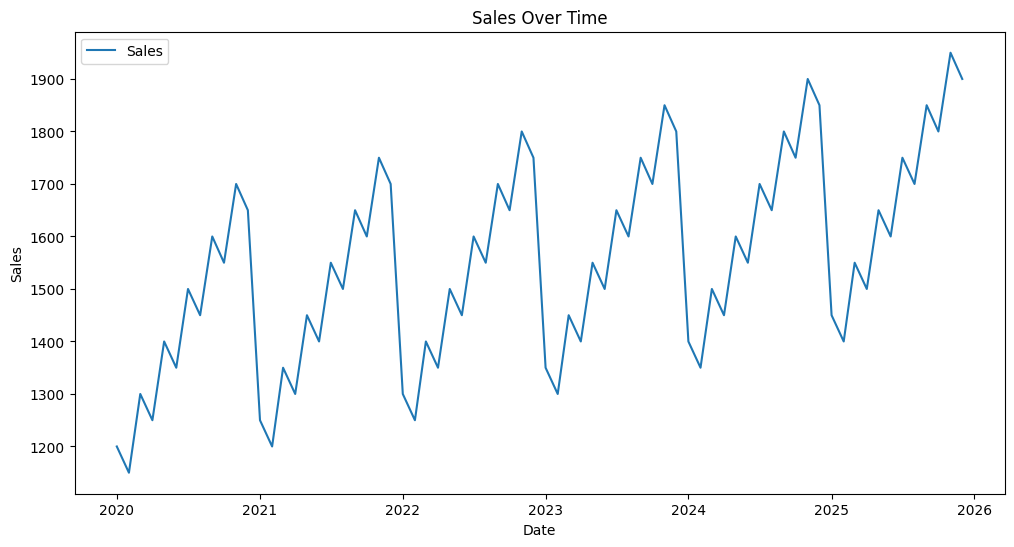

In [4]:
# Plot the sales time series
# Ensure the date column is parsed as datetime and set as index if not already
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
plt.figure(figsize=(12,6))
plt.plot(df['sales'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Split Data into Training and Test Sets
Split the time series into training and test sets, preserving the temporal order. Typically, the last 20% of the data is used as the test set.

In [5]:
# Split the data into training and test sets
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]
print(f"Training set: {train.shape}")
print(f"Test set: {test.shape}")

Training set: (57, 1)
Test set: (15, 1)


## Check for Stationarity and Differencing
Perform stationarity tests (e.g., Augmented Dickey-Fuller), visualize rolling statistics, and apply differencing if necessary.

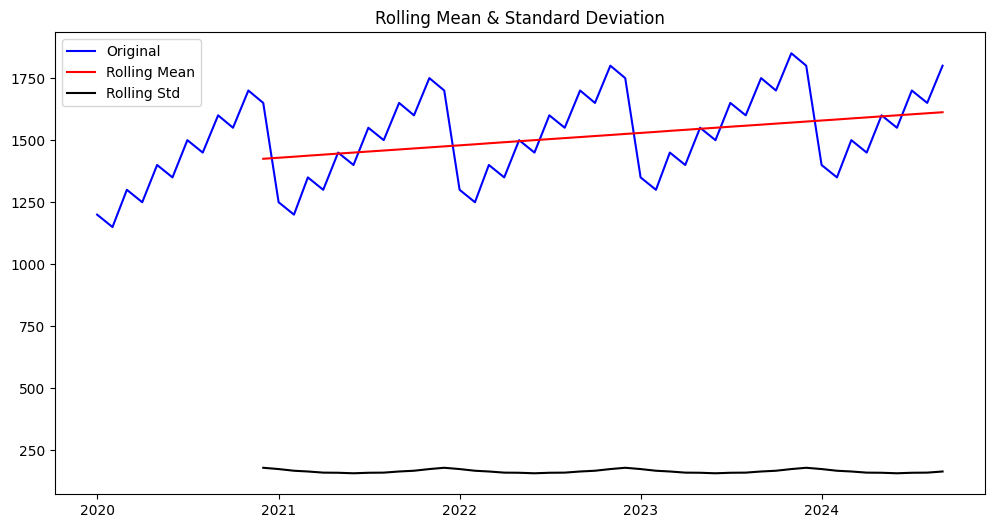

ADF Statistic: -0.010985
p-value: 0.957614
Critical Value 1%: -3.584828853223594
Critical Value 5%: -2.9282991495198907
Critical Value 10%: -2.6023438271604937
Series is likely non-stationary.


In [6]:
# Visualize rolling statistics
rolmean = train['sales'].rolling(window=12).mean()
rolstd = train['sales'].rolling(window=12).std()
plt.figure(figsize=(12,6))
plt.plot(train['sales'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] < 0.05:
        print('Series is likely stationary.')
    else:
        print('Series is likely non-stationary.')
adf_test(train['sales'])

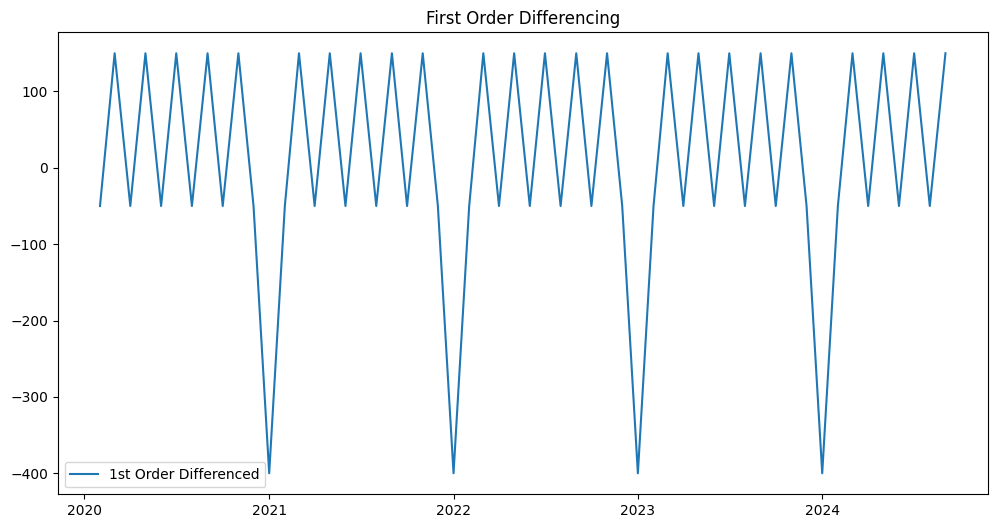

ADF Statistic: -6831291452218.740234
p-value: 0.000000
Critical Value 1%: -3.5885733964124715
Critical Value 5%: -2.929885661157025
Critical Value 10%: -2.6031845661157025
Series is likely stationary.


In [7]:
# If the series is non-stationary, apply first-order differencing and re-test
train_diff = train['sales'].diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(train_diff, label='1st Order Differenced')
plt.title('First Order Differencing')
plt.legend()
plt.show()
adf_test(train_diff)

## Fit SARIMA Model on Training Data
Select SARIMA parameters, fit the model to the training data, and display the model summary.

In [8]:
# Fit SARIMA model (example parameters, tune as needed)
# (p,d,q) x (P,D,Q,s)
model = SARIMAX(train['sales'], order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.12109D-01    |proj g|=  4.61227D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     23      1     0     0   3.569D+05  -5.716D+00
  F =  -5.7162237579337196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   57
Model:      

 This problem is unconstrained.


## Forecast Future Sales
Use the fitted SARIMA model to forecast sales for the test period and plot the forecasts against actual sales.

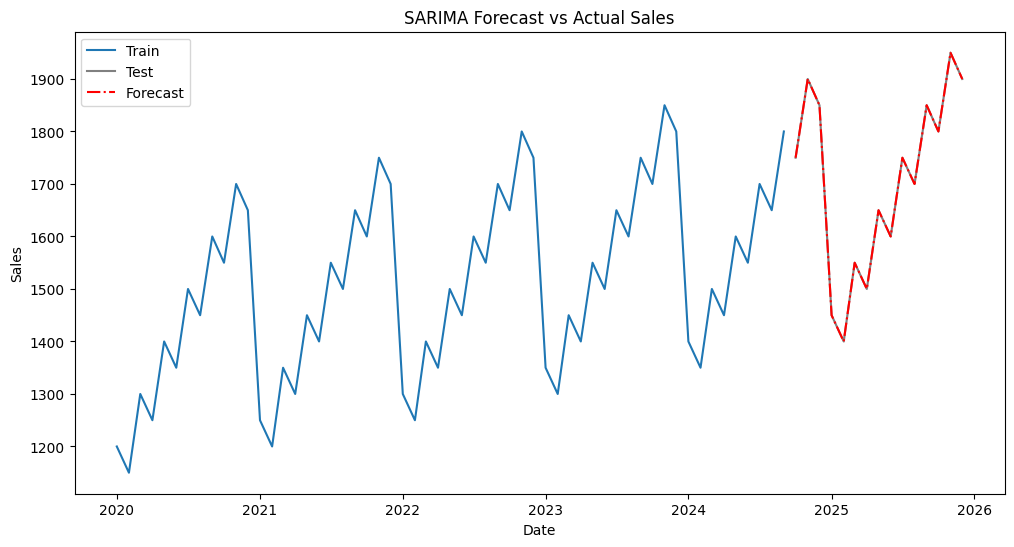

In [9]:
# Forecast for the test period
n_test = len(test)
pred = results.get_forecast(steps=n_test)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test', color='gray')
plt.plot(test.index, pred_mean, label='Forecast', color='red', linestyle='-.')
plt.fill_between(test.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Evaluate Forecast Performance
Calculate evaluation metrics such as MAE, RMSE, and MAPE to assess the accuracy of the forecasts.

In [10]:
# Calculate evaluation metrics
mae = mean_absolute_error(test['sales'], pred_mean)
rmse = np.sqrt(mean_squared_error(test['sales'], pred_mean))
mape = np.mean(np.abs((test['sales'] - pred_mean) / test['sales'])) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.00
RMSE: 0.00
MAPE: 0.00%


## Conclusion
In this notebook, we performed time series analysis and forecasting using the SARIMA model on sales data. We explored the data, checked for stationarity, fit a SARIMA model, made forecasts, and evaluated the results using standard metrics. Further improvements can be made by tuning the SARIMA parameters and exploring other time series models.